In [18]:
from matplotlib import pyplot as plt
import numpy as np
import csv
import math
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix

### Read data

In [3]:
data = pd.read_csv('dados_voz_genero.csv', delimiter = ',')
#data = data.drop("Unnamed: 0", axis=1)
names = list(data.keys())
data.sample(5)

,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
1356,0.059287,0.236642,0.148881,0.257537,0.108657,1.588147,4.770636,0.877106,0.271041,0.249179,0.207792,0.141775,0.047105,0.266667,0.949836,0.023438,4.921875,4.898438,0.098508,1.0
2125,0.033228,0.183704,0.171481,0.198148,0.026667,2.833365,12.110202,0.845921,0.239098,0.187963,0.183107,0.167326,0.020305,0.253968,1.007812,0.007812,6.625000,6.617188,0.222989,0.0
1414,0.059687,0.174872,0.120513,0.215897,0.095385,1.043384,3.857072,0.933133,0.509799,0.164103,0.172894,0.131851,0.047431,0.277457,1.231086,0.023438,7.406250,7.382812,0.094084,1.0
1055,0.053220,0.203671,0.129644,0.222849,0.093205,2.066273,7.260472,0.892495,0.339382,0.214411,0.184142,0.125153,0.047244,0.277457,0.795573,0.023438,6.046875,6.023438,0.097356,1.0
909,0.078562,0.183623,0.125290,0.254638,0.129348,1.976600,6.734309,0.927683,0.551486,0.247536,0.181560,0.132376,0.052174,0.271186,0.472005,0.023438,4.382812,4.359375,0.059140,1.0


### Check balance

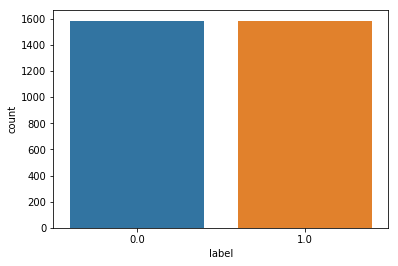

In [4]:
sns.countplot(x='label', data=data)
plt.show()

Data is balanced

### Prepare data

In [5]:
def sigmoid(z):
    import numpy as np
    sigm = 1/(1+np.exp(-z))
    return sigm

def loss(h, y):
    import numpy as np
    loss = (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    return loss

def normalize(x, interval):
    import numpy as np
    x1 = np.array(x)
    x_normalized =  interval[0] + (x1 - min(x))*(interval[1] - interval[0])/(max(x) - min(x))
    return x_normalized

In [6]:
# Divide X and y
names = list(data.keys())

X = data.copy()
left_ones = np.ones(data.shape[0])
X['ones'] = left_ones
X = X.drop(columns = 'label')

cols = list(X.columns)
cols = [cols[-1]] + cols[:-1]
X = X[cols]

for i in range(1,X.shape[1] -1):
    X.iloc[:,i] = normalize(X.iloc[:,i], [-1,1])
    
y = data['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Make and train model

Iteration: 1000 -- Training Loss: 0.0850459390353238 -- Validation Loss: 0.12398056695511134
Amount of iterations after the current minimum loss function on the validation set: 0
Iteration: 2000 -- Training Loss: 0.069980321526302 -- Validation Loss: 0.12002111563852336
Amount of iterations after the current minimum loss function on the validation set: 190
Iteration: 3000 -- Training Loss: 0.06418808576250978 -- Validation Loss: 0.12239203778436217
Amount of iterations after the current minimum loss function on the validation set: 1190
Iteration: 4000 -- Training Loss: 0.06103184690093172 -- Validation Loss: 0.12571673189188004
Amount of iterations after the current minimum loss function on the validation set: 2190
Iteration: 5000 -- Training Loss: 0.05901028442387616 -- Validation Loss: 0.1290617232342129
Amount of iterations after the current minimum loss function on the validation set: 3190
Iteration: 6000 -- Training Loss: 0.05758393136692977 -- Validation Loss: 0.13220771987298124

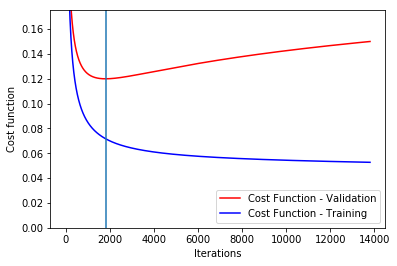

In [13]:
# Inicialize weights
VAL_PROPORTION = 0.9
theta = np.zeros(X_train.shape[1])

ls_training = []
ls_val = []

# Learning rate
lr = 0.5

# Threshold
threshold = 0.5

# Number of iterations
iterations = 100000

#Number of additional iterations after a minimum on validation set
MAX_IT_AFTER_MIN = 12000
it_after_min = 0
min_cost_val = 2**10 #high number

# Training loop
X_training, X_val, y_training, y_val = train_test_split(X_train, y_train, test_size=VAL_PROPORTION, random_state=42)


for i in range(iterations):
    it_after_min = it_after_min + 1   
    
    # Input x Weights
    z = np.dot(X_training, theta)    
    # Sigmoid
    h_training = sigmoid(z)
    # Gradient descent
    gradient = np.dot(X_training.transpose() , h_training - y_training)/y_training.size
    theta = theta - lr * gradient
    
    h_training = sigmoid(np.dot(X_training, theta))
    ls_training.append(loss(h_training, y_training))

    h_val = sigmoid(np.dot(X_val, theta))
    ls_val.append(loss(h_val, y_val))
    
    if ls_val[-1] < min_cost_val:
        it_after_min = 0
        opt_theta = theta
        min_cost_val = ls_val[-1]
        best_it_idx = i
        
    if it_after_min == MAX_IT_AFTER_MIN:
        print('Iteration: {} -- Training Loss: {} -- Validation Loss: {}'. format(i, ls_training[-1], ls_val[-1]))
        break        
    
    # Print info
    if((i+1)%1000 == 0):        
        print('Iteration: {} -- Training Loss: {} -- Validation Loss: {}'. format(i+1, ls_training[-1], ls_val[-1]))
        print('Amount of iterations after the current minimum loss function on the validation set: {}'.format(it_after_min))
theta = opt_theta
        
plt.plot(ls_val, color = 'red', label="Cost Function - Validation")
plt.plot(ls_training, color = 'blue', label ="Cost Function - Training")
plt.axvline(x=best_it_idx)
plt.ylim(0, 0.175)
plt.xlabel('Iterations')
plt.ylabel('Cost function')
plt.legend()
plt.show()

### Test model

In [14]:
# Predict probability
prob = sigmoid(np.dot(X_test, theta))
y_pred = prob >= threshold

### Metrics

Accuracy: 0.9716088328075709
F1 Score: 0.973293768545994


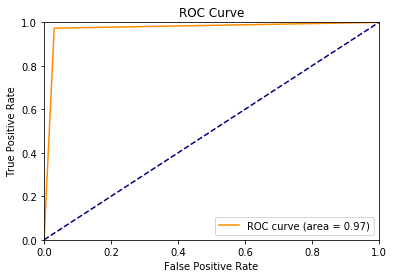

In [15]:
# Accuracy
print('Accuracy: {}'.format((y_pred == y_test).mean()))

# F1 Score
print('F1 Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Choosing threshold

Highest Accuracy: 0.9732 - Threshold: 0.40
Highest F1 Score: 0.9750 - Threshold: 0.40
Highest ROC Area: 0.9726 - Threshold: 0.40


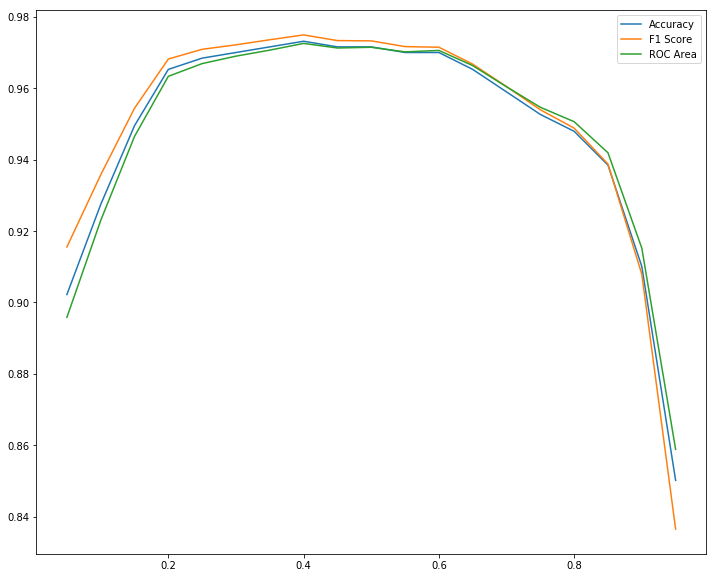

In [16]:
thresholds = np.linspace(0.05,0.95,19)
acc = []
f1s = []
roc = []

for th in thresholds:
    y_pred = prob >= th
    
    # Title
    #print('Threshold: {}'.format(th))
    
    # Accuracy
    #print('Accuracy: {}'.format((y_pred == y_test).mean()))

    # F1 Score
    #print('F1 Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #print('ROC Area: {}'.format(roc_auc))
    
    #print('---------------------------------------')
    
    '''
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()    
    '''
    
    acc.append((y_pred == y_test).mean())
    f1s.append(f1_score(y_test, y_pred, average='binary'))
    roc.append(roc_auc)
    
print('Highest Accuracy: {0:.4f} - Threshold: {1:.2f}'.format(np.max(acc), thresholds[acc.index(np.max(acc))]))
print('Highest F1 Score: {0:.4f} - Threshold: {1:.2f}'.format(np.max(f1s), thresholds[f1s.index(np.max(f1s))]))
print('Highest ROC Area: {0:.4f} - Threshold: {1:.2f}'.format(np.max(roc), thresholds[roc.index(np.max(roc))]))
    
plt.figure(figsize = (12,10))
plt.plot(thresholds, acc, label='Accuracy')
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, roc, label='ROC Area')
plt.legend()
plt.show()

### Accuracy and Confusion matrix using the chosen threshold

Accuracy for threshold 0.50: 0.9716


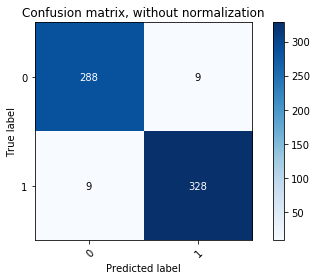

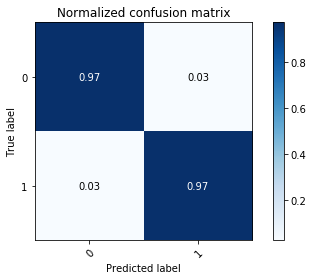

In [19]:
# Most adequate threshold (largest roc area?)
th = 0.5
y_pred = prob >= th

# Accuracy
print('Accuracy for threshold {0:.2f}: {1:.4f}'.format(th, (y_pred == y_test).mean()))

# Confusion matrix
normalize = False
cm = confusion_matrix(y_test, y_pred)
cmap = plt.cm.Blues
classes = ['0', '1']

for normalize in [False, True]:

    # Normalization
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()